<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*The Bernstein-Vazirani Algorithm*_ 

In this tutorial, we introduce the [Bernstein-Vazirani algorithm](http://epubs.siam.org/doi/abs/10.1137/S0097539796300921), which is one of the earliest algorithms demonstrating the power of quantum computing. Despite its simplicity, it is often used and is the inspiration for many other quantum algorithms even today; it is the basis of the power of the short-depth quantum circuits, as in [Bravyi et al.](https://arxiv.org/abs/1704.00690) that uses its non-oracular version, or in [Linke et al.](http://www.pnas.org/content/114/13/3305.full) that uses it to test the performance of the quantum processors (see also the [talk by Ken Brown](https://www.youtube.com/watch?v=eHV9LTiePrQ) at the ThinkQ 2017 conference). Here, we show the implementation of the Bernstein-Vazirani algorithm **without using entanglement** based on [Du et al.](https://arxiv.org/abs/quant-ph/0012114) on Qiskit and test it on IBM Q systems. 

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Rudy Raymond

## Introduction <a id='introduction'></a>

The Bernstein-Vazirani algorithm deals with finding a hidden integer $a \in \{0,1\}^n$ from an oracle $f_a$ that returns a bit $a \cdot x \equiv \sum_i a_i x_i \mod 2$ upon receiving an input $x \in \{0,1\}^n$. A classical oracle returns $f_a(x) = a \cdot x \mod 2$ given an input $x$. Meanwhile, a quantum oracle behaves similarly but can be queried with superposition of input $x$'s. 

Classically, the hidden integer $a$ can be revealed by querying the oracle with $x = 1, 2, \ldots, 2^i, \ldots, 2^{n-1}$, where each query reveals the $i$-th bit of $a$ (or, $a_i$). For example, with $x=1$ one can obtain the least significant bit of $a$, and so on. This turns out to be an optimal strategy; any classical algorithm that finds the hidden integer with high probability must query the oracle $\Omega(n)$ times. However, given a corresponding quantum oracle, the hidden integer can be found with only $1$ query using the Bernstein-Vazirani algorithm. 

## The Algorithm

The Bernstein-Vazirani algorithm to find the hidden integer is very simple: start from a $|0\rangle$ state, apply Hadamard gates, query the oracle, apply Hadamard gates, and measure. The correctness of the algorithm is best explained by looking at the transformation of a quantum register $|a \rangle$ by $n$ Hadamard gates, each applied to the qubit of the register. It can be shown that

$$
|a\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle.
$$

In particular, when we start with a quantum register $|0\rangle$ and apply $n$ Hadamard gates to it, we have the familiar quantum superposition as below

$$
|0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle,
$$

which is slightly different from the Hadamard transform of the reqister $|a \rangle$ by the phase $(-1)^{a\cdot x}$. 

Now, the quantum oracle $f_a$ returns $1$ on input $x$ such that $a \cdot x \equiv 1 \mod 2$, and returns $0$ otherwise. This means we have the following transformation:

$$
|x \rangle \left(|0\rangle - |1\rangle \right) \xrightarrow{f_a} | x \rangle \left(|0 \oplus f_a(x) \rangle - |1 \oplus f_a(x) \rangle \right) = (-1)^{a\cdot x} |x \rangle \left(|0\rangle - |1\rangle \right). 
$$

Notice that the second register $|0\rangle - |1\rangle$ in the above does not change and can be omitted for simplicity. In short, the oracle can be used to create $(-1)^{a\cdot x}|x\rangle$ from the input $|x \rangle$. In this tutorial, we follow [Du et al.](https://arxiv.org/abs/quant-ph/0012114) to generate a circuit for a quantum oracle without the need of an ancilla qubit (often used in the standard quantum oracle). 

The algorithm to reveal the hidden integer follows naturally by querying the quantum oracle $f_a$ with the quantum superposition obtained from the Hadamard transformation of $|0\rangle$. Namely,

$$
|0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle \xrightarrow{f_a} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle.
$$

Because the inverse of the $n$ Hadamard gates is again the $n$ Hadamard gates, we can obtain $a$ by

$$
\frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle \xrightarrow{H^{\otimes n}} |a\rangle.
$$


## The (Inner-Product) Oracle <a id='oracle'></a>

Here, we describe how to build the oracle used in the Bernstein-Vazirani algorithm. The oracle is also referred to as the [inner-product oracle](https://arxiv.org/pdf/quant-ph/0108095.pdf) (while the oracle of the Grover search is known as the Equivalence, or EQ, oracle). Notice that it transforms $|x\rangle$ into $(-1)^{a\cdot x} |x\rangle$. Clearly, we can observe that

$$
(-1)^{a\cdot x} = (-1)^{a_1 x_1} \ldots (-1)^{a_ix_i} \ldots (-1)^{a_nx_n} = \prod_{i: a_i = 1} (-1)^{x_i}. 
$$

Therefore, the inner-product oracle can be realized by the following unitary transformation, which is decomposable as single-qubit unitaries: 

$$
O_{f_a} = O^1 \otimes O^2 \otimes \ldots \otimes O^i \otimes \ldots \otimes O^n, 
$$
where $O^i = (1 - a_i)I + a_i Z$, where $Z$ is the Pauli $Z$ matrix and $I$ is the identity matrix for $a_i \in \{0,1\}$. 

Notice that we start from a separable quantum state $|0\rangle$ and apply a series of transformations that are separable (i.e., can be described by unitaries acting on a single qubit): Hadamard gates to each qubit, followed by the call to the *decomposable* quantum oracle as [Du et al.](https://arxiv.org/abs/quant-ph/0012114), and another Hadamard gate. Hence, there is no entanglement created during the computation. This is in contrast with the circuit at [Linke et al.](http://www.pnas.org/content/114/13/3305.full) that used CNOT gates to realize the oracle and an ancilla qubit to store the answer of the oracle. 

## The Circuit <a id="circuit"></a>

We now implement the Bernstein-Vazirani algorithm with Qiskit by first preparing the environment.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [2]:
# Load our saved IBMQ accounts.
IBMQ.load_accounts()

We first set the number of qubits used in the experiment, and the hidden integer $a$ to be found by the Bernstein-Vazirani algorithm. The hidden integer $a$ determines the circuit for the quantum oracle. 

In [3]:
nQubits = 14 # number of physical qubits
a = 101      # the hidden integer whose bitstring is 1100101

# make sure that a can be represented with nQubits
a = a % 2**(nQubits)

We then use Qiskit to program the Bernstein-Vazirani algorithm.

In [4]:
# Creating registers
# qubits for querying the oracle and finding the hidden integer
qr = QuantumRegister(nQubits)
# for recording the measurement on qr
cr = ClassicalRegister(nQubits)

circuitName = "BernsteinVazirani"
bvCircuit = QuantumCircuit(qr, cr)

# Apply Hadamard gates before querying the oracle
for i in range(nQubits):
    bvCircuit.h(qr[i])
    
# Apply barrier so that it is not optimized by the compiler
bvCircuit.barrier()

# Apply the inner-product oracle
for i in range(nQubits):
    if (a & (1 << i)):
        bvCircuit.z(qr[i])
    else:
        bvCircuit.iden(qr[i])
        
# Apply barrier 
bvCircuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(nQubits):
    bvCircuit.h(qr[i])
    
# Measurement
bvCircuit.barrier(qr)
bvCircuit.measure(qr, cr)

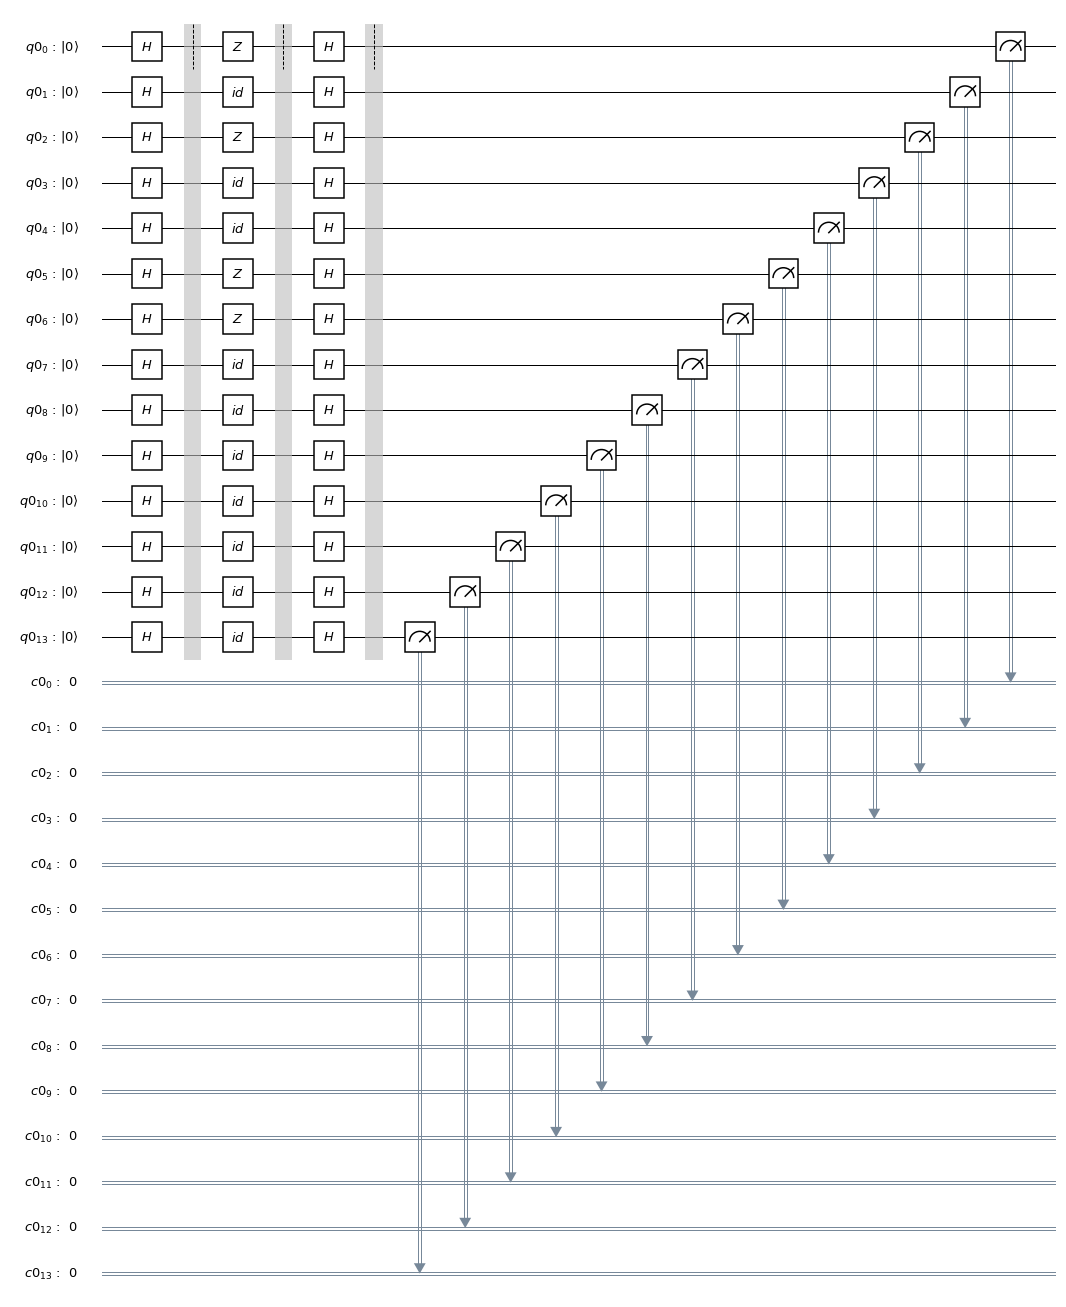

In [5]:
bvCircuit.draw(output='mpl')

## Experiment with Simulators

We can run the above circuit on the simulator. 

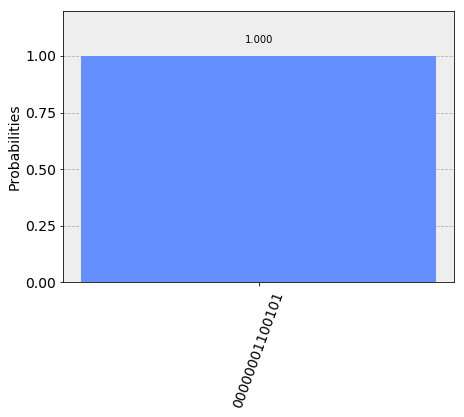

In [6]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
results = execute(bvCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

We can see that the result of the measurement is the binary representation of the hidden integer $a$. 

## Experiment with Real Devices

We can run the circuit on the real device as below.

In [7]:
backend = IBMQ.get_backend('ibmq_16_melbourne')
shots = 1000
job_exp = execute(bvCircuit, backend=backend, shots=shots)    
job_monitor(job_exp)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

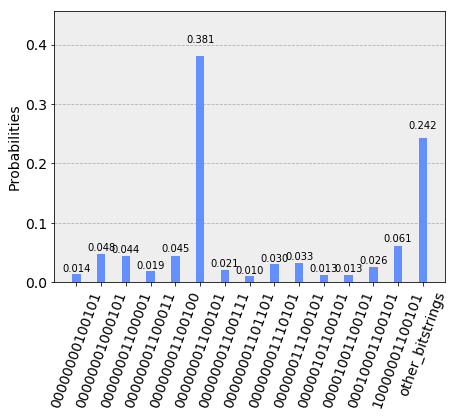

In [8]:
results = job_exp.result()
answer = results.get_counts(bvCircuit)

threshold = int(0.01 * shots) #the threshold of plotting significant measurements
filteredAnswer = {k: v for k,v in answer.items() if v >= threshold} #filter the answer for better view of plots

removedCounts = np.sum([ v for k,v in answer.items() if v < threshold ]) #number of counts removed 
filteredAnswer['other_bitstrings'] = removedCounts  #the removed counts is assigned to a new index

plot_histogram(filteredAnswer)

In [9]:
print(filteredAnswer)

{'00000001100100': 45, '00000001101101': 10, '00000000100101': 14, '00000001100101': 381, '00000001000101': 48, '10000001100101': 61, '00000001100111': 21, '00000101100101': 13, '00000001100011': 19, '00000011100101': 33, '00000001110101': 30, '00010001100101': 26, '00000001100001': 44, '00001001100101': 13, 'other_bitstrings': 242}


We indeed see that the outcome is the binary representation of the hidden integer $a$ with high probability. 